# A noisy detector

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.

(When detecting a signal, state-of-the-art gravitational-wave analysis make use of another tecnique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) which, unfortunately, we do not have time to cover here. But PCA is used to classify instrumental artifacts, see e.g. [Powell et al 2005](https://arxiv.org/abs/1505.01299)).

In [1]:
pip install numpy==1.20


  Using cached numpy-1.20.0-cp38-cp38-win_amd64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import FastICA, PCA, NMF
from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from scipy.optimize import curve_fit
import scipy
from scipy.stats import chi2

Collect the dataset

In [5]:
X=np.load("C:/Users/PC/Desktop/UNI/MAGISTRALE/Astrostatistics/noisydetector.npy")
X.shape

(2000, 3)

Call the PCA model and compute the eigenvalues and eigenvectors decomposition, in order to determine the Principal axis

In [6]:
# PCA 

pca = PCA(n_components=3) # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

(2000, 3)
(3, 3)


Plot the resulting 3 level decomposition. 

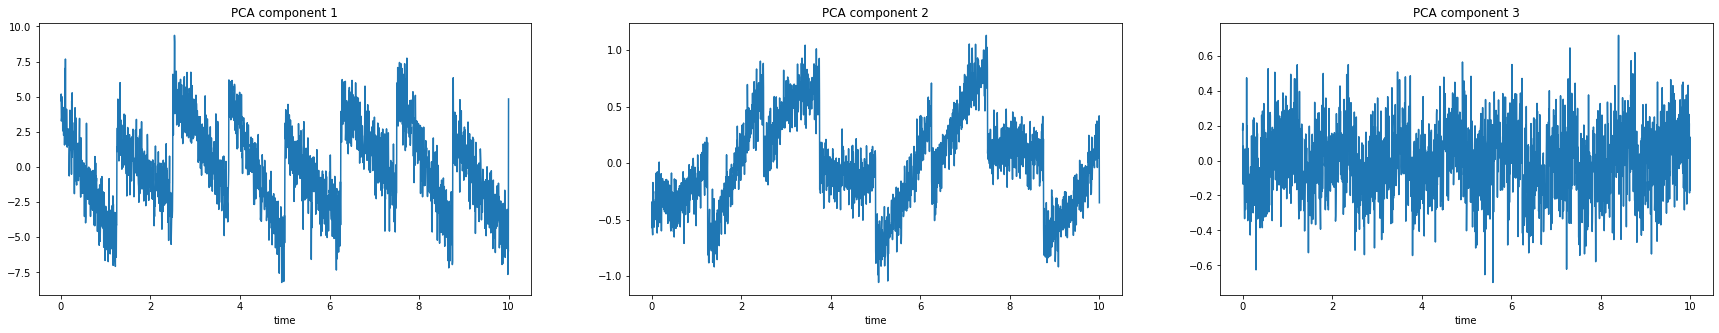

In [7]:
time = np.linspace(0,10,2000)

plt.figure(figsize=(30,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(time,eigenvalues[:,i])
    plt.title('PCA component %1.0f' % (i+1))
    plt.xlabel('time')
    

Let me try also NMF, checking that the basis are definite positive. Since they are not NMF doesn't work

In [7]:
nmf = NMF(n_components=3)
nmf.fit(X)

eigenvector = nmf.components_
eigenvalues = nmf.transform(X)

time = np.linspace(0,10,2000)

plt.figure(figsize=(30,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(time,eigenvalues[:,i])
    plt.title('ICA component %1.0f' % (i+1))
    plt.xlabel('time')

ValueError: Negative values in data passed to NMF (input X)

We can do better with an ICA algorithm. Which improve the selection maximising the non gaussianity. We can see our sinusoidal signal

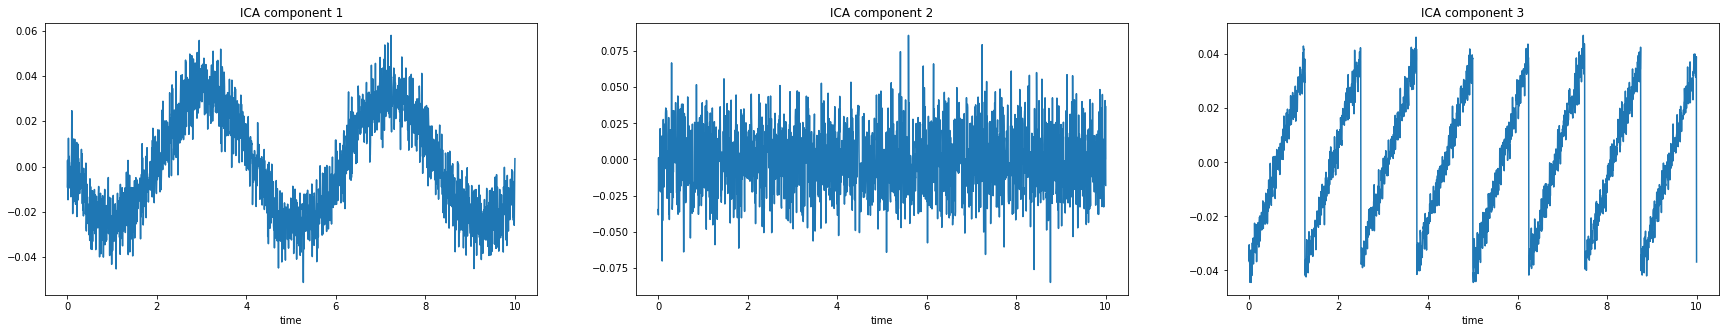

In [9]:
ica = FastICA(n_components=3)
ica.fit(X)

eigenvector = ica.components_
eigenvalues = ica.transform(X)

time = np.linspace(0,10,2000)

plt.figure(figsize=(30,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(time,eigenvalues[:,i])
    plt.title('ICA component %1.0f' % (i+1))
    plt.xlabel('time')

In [40]:
from numpy.random import choice

draws=choice(eigenvalues[:,0],1000000000)

plt.hist(draws, bins=100)

KeyboardInterrupt: 

I use jackknife to verify the corectness of PCA params. Than Since are not provided I choose (=0.224) measurments uncertianity. Resampling the ICA component 1, since the CLT, I obtain the range of possibiles sinusoids which corresponds to the width of the gaussian. Like montecarlo simulations.

In [9]:
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

data = eigenvalues[0:,0]
resamples = jackknife_resampling(data)
print(resamples.shape)

test_statistic = np.std
estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

print(estimate, bias, stderr, conf_interval)

err = np.array([0.0224 for i in range(2000)])
print(err.shape)

(2000, 1999)
0.02236763166197482 -6.951886976892807e-06 0.0002465212981034093 [0.02188446 0.0228508 ]
(2000,)


Now I use dynesty to estimate the parametrs and determine the period

In [10]:

def sinusoid(A,T,phi, t):
    return A*np.sin(2*np.pi*t/T+phi)

In [19]:
Amin,Amax=0,1
Tmin,Tmax=0,10
phimin,phimax=0,20 # phi = 2pi * (t-t0 / T)



def LogLikelihood(theta, model=sinusoid):
    A,T,phi = theta
    x, y, sigma_y = time, eigenvalues[0:,0], err
    y_fit = model(A,T,phi, x)
    
    #c=2
    #t = abs((y - y_fit) / sigma_y)
    #flag = t > c
    
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) # maybe better with huber loss function
                                                     # np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1) #


def ptform(u):
    
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    
    mins = [Amin,Tmin,phimin]
    maxs = [Amax,Tmax,phimax]
    
    x = mins + u* maxs-mins
    
    return x

sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim=3, nlive=1000) # nlive improve the resolution since the prior volume dosen't change a lot.
sampler.run_nested()
sresults = sampler.results



16409it [01:07, 243.36it/s, +1000 | bound: 30 | nc: 1 | ncall: 80257 | eff(%): 21.965 | loglstar:   -inf < -173.217 <    inf | logz: -189.515 +/-  0.130 | dlogz:  0.001 >  1.009]


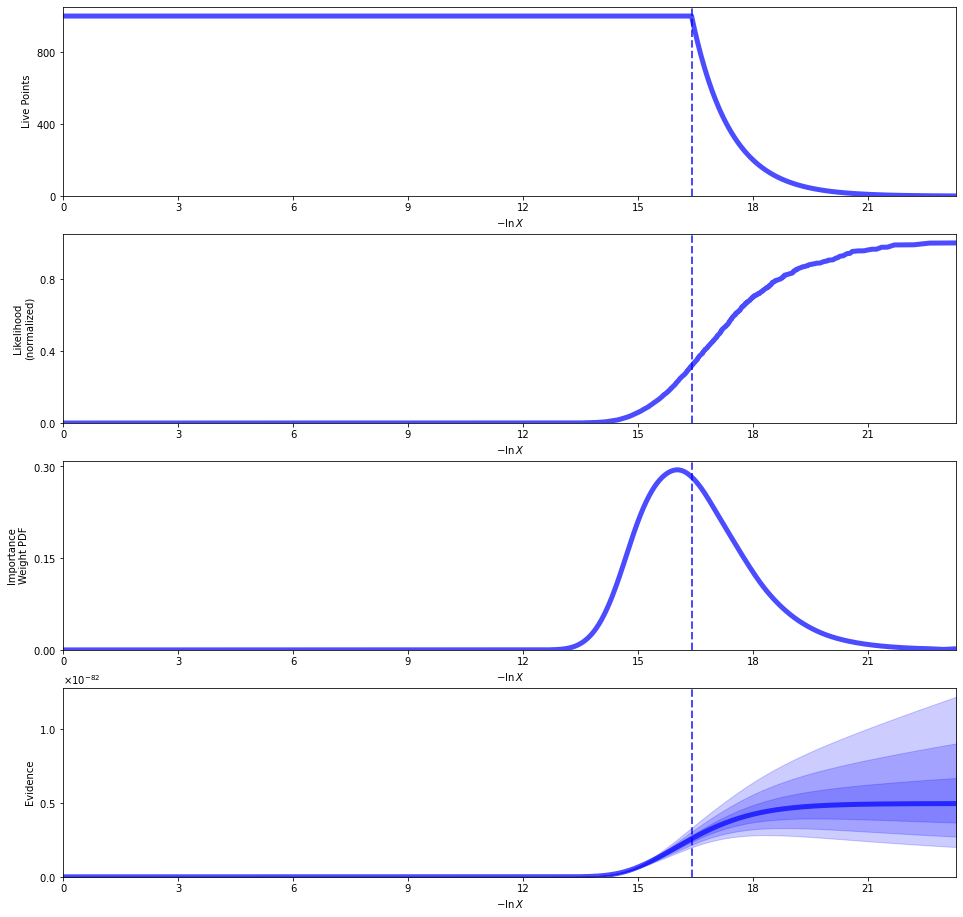

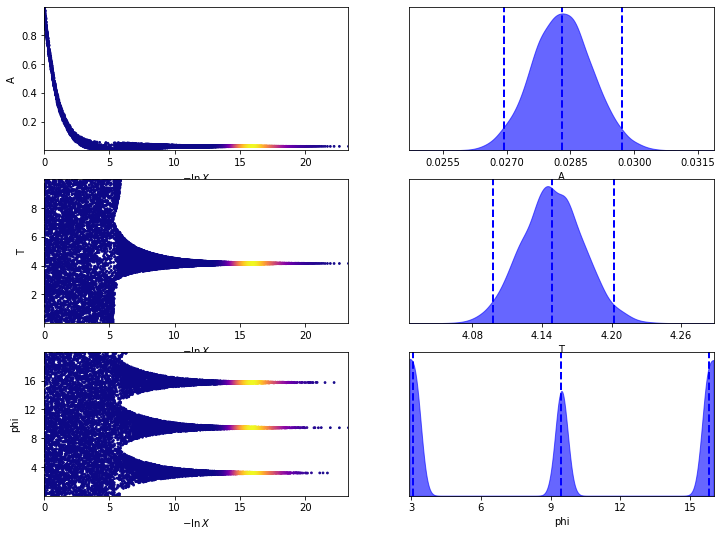

In [20]:
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults, labels=['A','T','phi'])


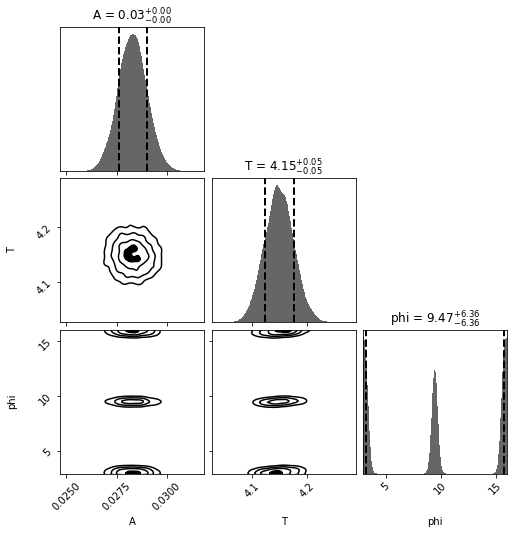

In [35]:
cfig, caxes = dyplot.cornerplot(sresults, labels=['A','T','phi'],color='black', truths=np.zeros(4),
                           truth_color='black', show_titles=True,
                           max_n_ticks=3, quantiles=[0.16, 0.84]
                           )

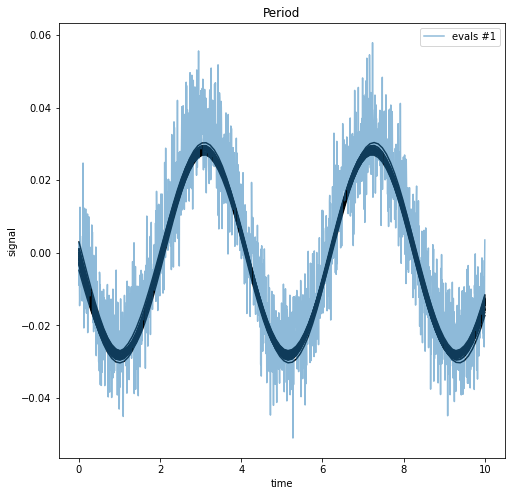

In [26]:
new_samples = sresults.samples_equal() # weights are equal 


tt=np.linspace(0,10,100)

random_samples = new_samples[np.random.randint(0,len(new_samples),30)]


plt.figure(figsize=(8,8))
for i in range(len(random_samples)):
    plt.plot(tt, sinusoid(random_samples[i][0],random_samples[i][1],random_samples[i][2] ,tt)
                ,c='black' )
    

plt.plot(time,eigenvalues[:,0], alpha=0.5, label='evals #1')
plt.title('ICA component 3')
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Period')
plt.legend(loc=0)

In [29]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1]) # normalized weight

# compute 10 and 90 % quantiles
quantiles = [dyfunc.quantile(samps,[0.16,0.84], weights=weights) for samps in samples.T]
print('68% credible regions for params are:' , (quantiles))

mean, cov = dyfunc.mean_and_cov(samples,weights)
print( (mean,cov))

68% credible regions for params are: [[0.027604194930079328, 0.02900712021385659], [4.122207164328675, 4.175159717155799], [3.1777476448219972, 15.755130758672577]]
(array([0.02830174, 4.14885561, 9.47481203]), array([[ 5.00269592e-07, -1.36063954e-06,  9.27320384e-05],
       [-1.36063954e-06,  6.92885842e-04,  3.91739572e-03],
       [ 9.27320384e-05,  3.91739572e-03,  2.64664745e+01]]))


For comparison I use also a frequentist approch. I assume gaussianity (checked) in order to use $\chi^2$ minimization and I determin a period consistent with the previous analysis.

A=-0.028$\pm$ 0.000
 T=4.148$\pm$ 0.000
 $\phi$=0.039$\pm$ 0.000



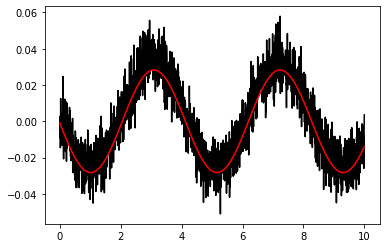

In [60]:
sinefunc= lambda t,A,T,phi: A*np.sin(2*np.pi*t/T+phi)

x=time
y=eigenvalues[:,0]

init_par = [0.04,4,0]


popt,pcov = scipy.optimize.curve_fit(sinefunc,x,y, p0=init_par)
A,T,phi = popt

chisq = sum(((sinusoid(x,A, T, phi)-y)/err)**2)

ndf = len(time)-len(popt)

Q = 1. -chi2.cdf(chisq, ndf)

chisq = chisq/ndf

A_err, T_err, phi_err, = np.sqrt(np.diag(pcov)/chisq)

xx=np.linspace(0,10,100)
plt.plot(time,eigenvalues[:,0],color='black')
plt.plot(xx,sinusoid(A, T, phi,xx), color='red')

print('A=%1.3f$\pm$ %1.3f\n T=%1.3f$\pm$ %1.3f\n $\phi$=%1.3f$\pm$ %1.3f\n' % (A,A_err,T,T_err,phi,phi_err))